In [1]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims

/tmp/ipykernel_261758/1448159700.py:8: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_261758/1448159700.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:

device = "cuda"
print("loading model")
model = HookedTransformer.from_pretrained(
    "gpt2-xl",
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    refactor_factored_attn_matrices=True,
    device=device,
)
# model.to(device)
print("done")
model.set_use_attn_result(True)
model.cfg.total_heads = model.cfg.n_heads * model.cfg.n_layers

model.reset_hooks()

loading model


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
done


In [3]:
from utils.dataset_utils import MS_Dataset, Elem_Dataset, MisCons_Dataset, Kinder_Dataset, HS_Dataset, BoolQ_Question_Dataset
random_seed = 5

datanames = ["MS", "Elem", "MisCons", "Kinder", "HS", "BoolQ"]

ms_data = MS_Dataset(model.tokenizer, questions=True)
elem_data = Elem_Dataset(model.tokenizer, questions=True)
miscons_data = MisCons_Dataset(model.tokenizer, questions=True)
kinder_data = Kinder_Dataset(model.tokenizer, questions=True)
hs_data = HS_Dataset(model.tokenizer, questions=True)
boolq_data = BoolQ_Question_Dataset(model.tokenizer)

datasets = {"MS": ms_data, "Elem": elem_data, "MisCons": miscons_data, "Kinder": kinder_data, "HS": hs_data, "BoolQ": boolq_data}

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--elem_tf-64ec49cd4cd5be64/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--ms_tf-728c6138d8f6c1c5/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--misconceptions_tf-131f43b181040ffa/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--kindergarten_tf-e3c53e366bc35ec1/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--hs_tf-9f911d9357ff2386/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
n_acts = 1000
acts = {}

for name in datanames:
    acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "result", "logits"])
    model_acts: ModelActs = acts[name]
    model_acts.gen_acts(N=n_acts, id=f"{name}_gpt2xl_{n_acts}")
    # model_acts.load_acts(id=f"{name}_gpt2xl_{n_acts}", load_probes=False)
    model_acts.train_probes("z", max_iter=1000)


100%|██████████| 1000/1000 [01:13<00:00, 13.56it/s]


Stored at MS_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


Stored at Elem_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1000/1000 [01:10<00:00, 14.15it/s]


Stored at MisCons_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]


Stored at Kinder_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


Stored at HS_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1000/1000 [01:10<00:00, 14.22it/s]


Stored at BoolQ_gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:10<00:00, 114.36it/s]


In [ ]:
import utils.analytics_utils as analytics

for name in datanames:
    analytics.plot_probe_accuracies(acts[name]).show()

In [14]:
# Get difference in positive and negative logits

# Should be same number of positive and negative tokens
positive_str_tokens = ["Yes", "yes", " Yes", " yes", "True", "true", " True", " true"]
negative_str_tokens = ["No", "no", " No", " no", "False", "false", " False", " false"]

positive_tokens = [model.tokenizer(token).input_ids[0] for token in positive_str_tokens]
negative_tokens = [model.tokenizer(token).input_ids[0] for token in negative_str_tokens]

def tot_logit_diff(model_acts, use_probs=False, eps=1e-8):

    sample_labels = np.array(model_acts.dataset.all_labels)[model_acts.indices] # labels

    positive_sum = torch.empty(size=(model_acts.indices.shape[0],))
    negative_sum = torch.empty(size=(model_acts.indices.shape[0],))
    for idx, logits in enumerate(model_acts.stored_acts["logits"]):

        # if answer to statement is True, correct tokens is Yes, yes, ..., true
        correct_tokens = positive_tokens if sample_labels[idx] else negative_tokens
        incorrect_tokens = negative_tokens if sample_labels[idx] else positive_tokens

        correct_tokens = positive_tokens
        incorrect_tokens = negative_tokens


        if use_probs:
            probs = torch.nn.functional.softmax(logits, dim=1)
            positive_prob = probs[0, correct_tokens].sum(dim=-1)
            negative_prob = probs[0, incorrect_tokens].sum(dim=-1)
            positive_sum[idx] = positive_prob / (positive_prob + negative_prob + eps)
            negative_sum[idx] = negative_prob / (positive_prob + negative_prob + eps)

        else:
            positive_sum[idx] = logits[0, correct_tokens].sum(dim=-1)
            negative_sum[idx] = logits[0, incorrect_tokens].sum(dim=-1)

    return positive_sum, negative_sum

for name in datanames:
    positive_sum, negative_sum = tot_logit_diff(acts[name], use_probs=True)
    print(f"{name}, {positive_sum.mean()}, {negative_sum.mean()}, {(positive_sum.mean() - negative_sum.mean())*100}%")


MS, 0.7495259046554565, 0.2504740059375763, 49.905189514160156%
Elem, 0.7538266777992249, 0.24617330729961395, 50.76533508300781%
MisCons, 0.7596233487129211, 0.2403765618801117, 51.9246826171875%
Kinder, 0.7428668737411499, 0.2571330666542053, 48.57337951660156%
HS, 0.7598257064819336, 0.24017415940761566, 51.965152740478516%
BoolQ, 0.6142476201057434, 0.3857523500919342, 22.84952735900879%


In [11]:
from sklearn.metrics import accuracy_score

def get_datapoint_probe_acc(model_acts, point, label, act_type):
    """
    Get probe accuracy on one particular datapoint (one sample)
    Label is 0 or 1 (true or false)
    Datapoint is shape (num_probes, d_probe) (e.g. stored_acts["z"][i])
    """
    probe_accs = []
    # print(f"{point.shape=}")
    for idx, probe in enumerate(model_acts.probes[act_type]):
        y_pred = probe.predict_proba(point[idx].numpy().reshape(1, -1))
        # print(f"{label=}, {y_pred=}")
        # print(y_pred)
        # probe_accs.append(accuracy_score([label], y_pred))
        if label == 1.0:
            # then 1st is good
            probe_accs.append(y_pred[0][1])
        else:
            probe_accs.append(y_pred[0][0])
    return probe_accs

print(f"Average stored probe acc is {acts['MS'].probe_accs['z'].mean()}")
all_accs = 0
for i in range(100):
    point = einops.rearrange(acts["MS"].stored_acts["z"][i], "n_l n_h d_p -> (n_l n_h) d_p")
    label = acts["MS"].dataset.all_labels[acts["MS"].indices[i]]
    probe_accs = get_datapoint_probe_acc(acts["MS"], point, label, "z")
    all_accs += sum(probe_accs)/len(probe_accs)
print(all_accs / 100)



# "True or False: The first president of the United States was George Washington." label: True
# "True or False: The first president of the United States was John Adam." label: False


# "Tell me if the prompt is True or False \n The first president of the United States was George Washington. \n Print "true" fi it's true and "fFalse" if it's false" label: True
# "True or False: The first president of the United States was John Adam." label: False



Average stored probe acc is 0.6341541666666666
0.5432205873705304


In [9]:
from utils.iti_utils import patch_iti
n_acts = 1000

iti_acts = {}
for name in datanames:
    iti_acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "result", "logits"])
    cache_interventions = torch.zeros(size=(model.cfg.n_layers, model.cfg.n_heads, 64))
    patch_iti(model, acts[name], topk=50, alpha=20, use_MMD=True, model_device="cuda", cache_interventions=cache_interventions)
    model_acts: ModelActs = iti_acts[name]
    # model_acts.gen_acts(N=n_acts, id=f"iti_{name}_gpt2xl_{n_acts}")
    model_acts.load_acts(id=f"iti_{name}_gpt2xl_{n_acts}", load_probes=False)
    model_acts.train_probes("z", max_iter=1000)
    print(cache_interventions.sum())

100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]


Stored at iti_MS_gpt2xl_1000
tensor(-11.1584)


100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]


Stored at iti_Elem_gpt2xl_1000
tensor(82.9823)


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


Stored at iti_MisCons_gpt2xl_1000
tensor(67.4184)


100%|██████████| 1000/1000 [01:12<00:00, 13.80it/s]


Stored at iti_Kinder_gpt2xl_1000
tensor(133.2733)


100%|██████████| 1000/1000 [01:13<00:00, 13.56it/s]


Stored at iti_HS_gpt2xl_1000
tensor(37.5590)


100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]


Stored at iti_BoolQ_gpt2xl_1000
tensor(382.7564)


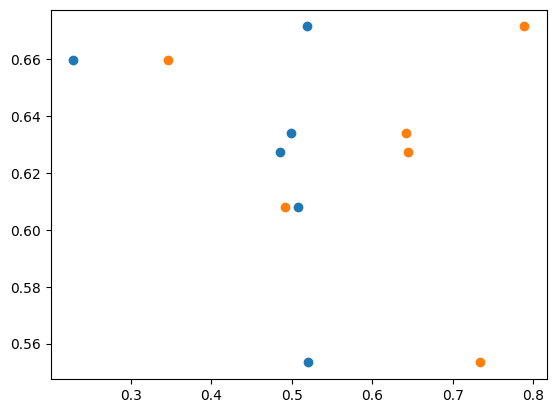

In [16]:
# plot graph of model accuracy differential vs probe accuracy
import matplotlib.pyplot as plt

colors=['b', 'r']
for idx, act_list in enumerate([acts, iti_acts]):
    model_acc_diffs = []
    probe_accs = []
    for name in datanames:
        positive_sum, negative_sum = tot_logit_diff(act_list[name], use_probs=True)
        model_acc_diffs.append(positive_sum.mean() - negative_sum.mean())

        probe_accs.append(acts[name].probe_accs["z"].mean())

    plt.scatter(probe_accs, model_acc_diffs, colors[idx])
plt.xlabel("Probe Accuracy")
plt.ylabel("Model Accuracy Differential")
plt.show()

100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


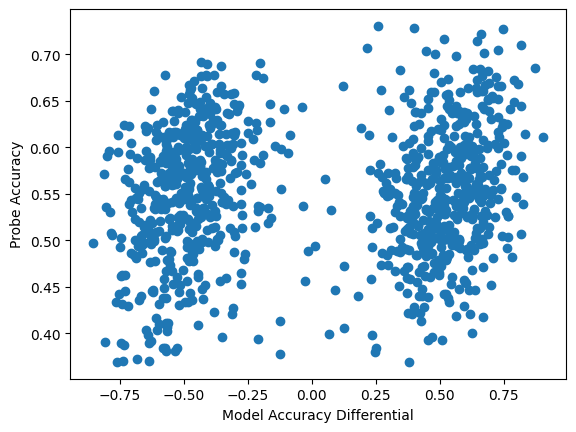

In [76]:
# plot graph of model accuracy differential vs probe accuracy


for name in datanames:

    probe_accs = []
    positive_sum, negative_sum = tot_logit_diff(acts[name], use_probs=True)
    model_acc_diffs = (positive_sum - negative_sum)
    for i in tqdm(range(1000)):
        point = einops.rearrange(acts["MS"].stored_acts["z"][i], "n_l n_h d_p -> (n_l n_h) d_p")
        label = acts["MS"].dataset.all_labels[acts["MS"].indices[i]]
        probe_acc = get_datapoint_probe_acc(acts["MS"], point, label, "z")
        probe_accs.append(sum(probe_acc)/len(probe_acc))
        
    plt.scatter(model_acc_diffs, probe_accs)

    break
plt.xlabel("Model Accuracy Differential")
plt.ylabel("Probe Accuracy")
plt.show()

In [78]:
for name in datanames:
    # acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "result", "logits"])
    model_acts: ModelActs = acts[name]
    model_acts.train_probes("resid_post", max_iter=10000)

torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:20<00:00,  2.39it/s]


torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


torch.Size([800, 48, 1600]), torch.Size([200, 48, 1600]), torch.Size([800, 48]), torch.Size([200, 48])


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


100%|██████████| 6/6 [00:59<00:00,  9.95s/it]


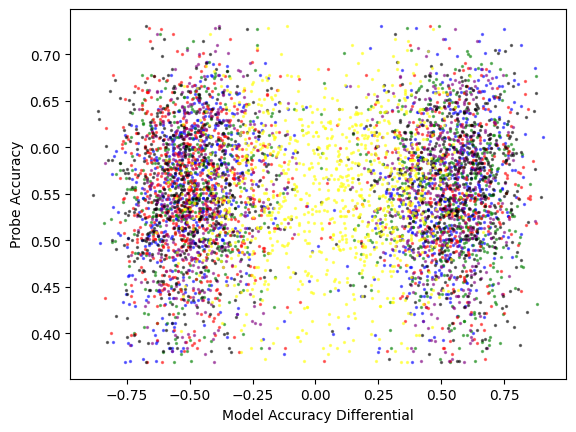

In [96]:
def get_data_probe_accs(model_acts, points, labels, act_type):
    """
    Get probe accuracy over multiple datapoints
    points in shape (batch, num_probes, d_probe)
    """
    # print(f"{point.shape=}")
    all_probe_accs = []
    for idx, probe in enumerate(model_acts.probes[act_type]):
        probe_accs = []
        y_pred = probe.predict_proba(points[:,idx].numpy())

        for data_idx, label in enumerate(labels):
            if label == 1.0:
                # then 1st is good
                probe_accs.append(y_pred[data_idx][1])
            else:
                probe_accs.append(y_pred[data_idx][0])
        all_probe_accs.append(probe_accs)

    return all_probe_accs


colors = {"MS": 'b', "Elem": 'g', "MisCons": 'r', "Kinder": 'purple', "HS": 'black', "BoolQ": 'yellow'}
for name in tqdm(datanames):

    positive_sum, negative_sum = tot_logit_diff(acts[name], use_probs=True)
    model_acc_diffs = (positive_sum - negative_sum)

    X_test = einops.rearrange(acts["MS"].stored_acts["z"], "b n_l n_h d_p -> b (n_l n_h) d_p")
    label = torch.tensor(acts["MS"].dataset.all_labels)[acts["MS"].indices]
    # print(label.shape)
    # print(X_test.shape)
    probe_accs = torch.tensor(get_data_probe_accs(acts["MS"], X_test, label, "z"))
    # print(probe_accs.shape)
    # probe_accs.append(sum(probe_acc)/len(probe_acc))
        
    plt.scatter(model_acc_diffs, probe_accs.mean(dim=0), color=colors[name], label=name, alpha=.5, s=2)

    # break
plt.xlabel("Model Accuracy Differential")
plt.ylabel("Probe Accuracy")
plt.show()

100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


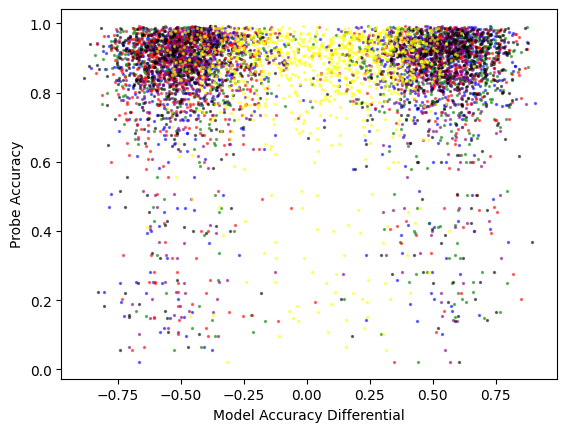

In [97]:
colors = {"MS": 'b', "Elem": 'g', "MisCons": 'r', "Kinder": 'purple', "HS": 'black', "BoolQ": 'yellow'}
for name in tqdm(datanames):

    positive_sum, negative_sum = tot_logit_diff(acts[name], use_probs=True)
    model_acc_diffs = (positive_sum - negative_sum)

    X_test = acts["MS"].stored_acts["resid_post"]
    label = torch.tensor(acts["MS"].dataset.all_labels)[acts["MS"].indices]
    # print(label.shape)
    # print(X_test.shape)
    probe_accs = torch.tensor(get_data_probe_accs(acts["MS"], X_test, label, "resid_post"))
    # print(probe_accs.shape)
    # probe_accs.append(sum(probe_acc)/len(probe_acc))
        
    plt.scatter(model_acc_diffs, probe_accs.mean(dim=0), color=colors[name], label=name, alpha=.5, s=2)

    # break
plt.xlabel("Model Accuracy Differential")
plt.ylabel("Probe Accuracy")
plt.show()

In [13]:
from utils.gpt_judge import get_iti_scores
plots = []

for name in datanames:
    get_iti_scores(model, datasets[name], alpha=20, topk=50)

100%|██████████| 1000/1000 [01:04<00:00, 15.41it/s]


Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:10<00:00, 117.21it/s]


truth_score=0.66, info_score=0.72, truth_score_iti=0.94, info_score_iti=0.26


/root/iti_capstone/utils/dataset_utils.py:156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
/root/iti_capstone/utils/dataset_utils.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
100%|█

Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:08<00:00, 137.77it/s]
/root/iti_capstone/utils/dataset_utils.py:156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
/root/iti_capstone/utils/dataset_utils.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return indices, np.array(self.all_prompts

truth_score=0.9, info_score=0.34, truth_score_iti=0.96, info_score_iti=0.12


100%|██████████| 1000/1000 [01:04<00:00, 15.43it/s]


Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:09<00:00, 123.93it/s]


truth_score=0.62, info_score=0.64, truth_score_iti=1.0, info_score_iti=0.02


In [14]:
from utils.gpt_judge import get_iti_scores
plots = []

for name in datanames:
    get_iti_scores(model, datasets[name], alpha=1, topk=1200)

100%|██████████| 1000/1000 [01:04<00:00, 15.48it/s]


Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:25<00:00, 46.49it/s] 


truth_score=0.52, info_score=0.7, truth_score_iti=0.74, info_score_iti=0.68


/root/iti_capstone/utils/dataset_utils.py:156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
/root/iti_capstone/utils/dataset_utils.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
100%|█

Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:08<00:00, 148.53it/s]
/root/iti_capstone/utils/dataset_utils.py:156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return indices, np.array(self.all_prompts)[indices], np.array(self.all_labels)[indices]
/root/iti_capstone/utils/dataset_utils.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return indices, np.array(self.all_prompts

truth_score=0.9, info_score=0.28, truth_score_iti=0.82, info_score_iti=0.44


100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


Stored at gpt2xl_1000
torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:09<00:00, 120.51it/s]


truth_score=0.74, info_score=0.66, truth_score_iti=0.7, info_score_iti=0.74


In [9]:
from plotly.subplots import make_subplots
from utils.gpt_judge import check_iti_generalization
plots = []

for name in datanames:
    model_acts: ModelActs = acts[name]
    for other_name in datanames:
        print(f"Checking generation on {name}, ITI on {other_name}")
        results = check_iti_generalization(model, datasets[name], datasets[other_name], 50, 1000, alpha=1, topk=1200, existing_gen_acts=model_acts)
        print(f"Truth score before ITI: {results[0]}, Truth score after ITI: {results[2]}")
        print(f"Info score before ITI: {results[1]}, Info score after ITI: {results[3]}")
        print()

        break
    break

        # transfer_accs = model_acts.get_transfer_acc(acts[other_name])
        # plots.append(plot_probe_accuracies(model_acts, sorted=False, title=f"{name} probes on {other_name} data", other_head_accs=transfer_accs).show())

Checking generation on tqa, ITI on tqa
truth_score=0.58, info_score=0.7, truth_score_iti=0.7, info_score_iti=0.7
Truth score before ITI: 0.58, Truth score after ITI: 0.7
Info score before ITI: 0.7, Info score after ITI: 0.7



In [14]:
from plotly.subplots import make_subplots
from utils.gpt_judge import check_iti_generalization
plots = []

np.seterr(all="ignore")
for name in datanames[1:]:
    model_acts: ModelActs = acts[name]
    for other_name in datanames:
        print(f"Checking generation on {name}, ITI on {other_name}")
        results = check_iti_generalization(model, datasets[name], datasets[other_name], 50, 1000, alpha=10, existing_gen_acts=acts[name])
        print(f"Truth score before ITI: {results[0]}, Truth score after ITI: {results[2]}")
        print(f"Info score before ITI: {results[1]}, Info score after ITI: {results[3]}")
        print()

        # transfer_accs = model_acts.get_transfer_acc(acts[other_name])
        # plots.append(plot_probe_accuracies(model_acts, sorted=False, title=f"{name} probes on {other_name} data", other_head_accs=transfer_accs).show())

Checking generation on cfact, ITI on tqa
truth_score=0.84, info_score=0.32, truth_score_iti=0.92, info_score_iti=0.3
Truth score before ITI: 0.84, Truth score after ITI: 0.92
Info score before ITI: 0.32, Info score after ITI: 0.3

Checking generation on cfact, ITI on cfact
truth_score=0.92, info_score=0.36, truth_score_iti=0.9, info_score_iti=0.32
Truth score before ITI: 0.92, Truth score after ITI: 0.9
Info score before ITI: 0.36, Info score after ITI: 0.32

Checking generation on cfact, ITI on ez
truth_score=0.8, info_score=0.52, truth_score_iti=0.92, info_score_iti=0.26
Truth score before ITI: 0.8, Truth score after ITI: 0.92
Info score before ITI: 0.52, Info score after ITI: 0.26

Checking generation on ez, ITI on tqa
truth_score=0.68, info_score=0.66, truth_score_iti=0.78, info_score_iti=0.6
Truth score before ITI: 0.68, Truth score after ITI: 0.78
Info score before ITI: 0.66, Info score after ITI: 0.6

Checking generation on ez, ITI on cfact
truth_score=0.74, info_score=0.6, trut

In [ ]:
import plotly.graph_objects as go

fig_combined = make_subplots(rows=3, cols=3)

for i, fig in enumerate(plots):
    row = i // 3 + 1  # calculate the row index
    col = i % 3 + 1   # calculate the column index

    # Extract data from the individual figures and add it to the subplots
    for trace in fig.data:
        fig_combined.add_trace(
            go.Heatmap(
                z=trace.z,
                x0=trace.x[0],
                dx=trace.x[1] - trace.x[0],
                y0=trace.y[0],
                dy=trace.y[1] - trace.y[0],
                zmin=trace.zmin,
                zmax=trace.zmax,
                coloraxis=trace.coloraxis,
                showscale=False,
            ),
            row=row,
            col=col,
        )

# Add a colorbar that's common to all subplots
fig.update_layout(coloraxis=dict(colorscale='viridis', colorbar=dict(tickfont=dict(size=10))))

fig.show()

In [ ]:
plots